In [1]:
import os
import sys

In [2]:
home = os.environ['HOME']
work_path = os.path.join(home, 'far/farMe/landau')
src_path = os.path.join(home, 'far/PHARE')
build_path = os.path.join(home, 'far/builds/release/landau')

In [3]:
sys.path.append(os.path.join(src_path, "pyphare"))

In [4]:
import subprocess
import pyphare
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from pyphare.core.operators import dot, cross, sqrt, modulus, grad
from pyphare.core.ufuncs import gF, peakIds
import numpy as np
from numpy import polyfit

# The ion acoustic wave

## Real part of the angular frequency

The mode that we are dealing with is the only linear unmagnetized electrostatic mode at low frequency, that is the ion acoustic mode. For this mode, one defines the ion acoustic speed as
$$
c_s = \left( \frac{\gamma_e k_B T_e + \gamma_i k_B T_i}{m_i} \right)^{1/2}
$$
For isothermal electrons, one has $\gamma_e = 1$ and for 1-dimensional adiabatic ions, $\gamma_i = 3$.
Hence, the real part of the angular frequency simply writes
$$
\omega_r = k c_s
$$
We already checked that this is the velocity at which the weak perturbation is propagating. We retrieve this velocity easily in the calculation as the mode is non-dispersive, so each component of a wave packet is traveling at the same speed, hence all the mode in the initial gaussian fluctuation of $V_1$.

This mode is propagating under the approximation
$$
\left( \frac{k_B T_i}{m_i} \right)^{1/2} < \frac{\omega}{k} < \left( \frac{k_B T_e}{m_e} \right)^{1/2}
$$

The second inequality is always satisfied in the hybrid case as $m_e \to 0$. To satisfy the first one, we need to be in the case $T_i < T_e$.

In [5]:
Ti = 0.1
Te = 0.2
run_name = "ld_real"

In [6]:
run_path = os.path.join(work_path, run_name)

In [7]:
if os.path.isdir(run_path):
    files = os.listdir(run_path)
else:
    files = []

In [8]:
if 'PYTHONPATH' in os.environ:
    os.environ['PYTHONPATH'] += os.pathsep + os.path.join(src_path, "pyphare")
else:
    os.environ['PYTHONPATH'] = os.pathsep + os.path.join(src_path, "pyphare")
os.environ['PYTHONPATH'] += os.pathsep + build_path

In [9]:
if 'EM_E.h5' not in files :
    os.chdir(work_path)
    # subprocess.run(['mpirun', '-n', '2', '/usr/bin/python3', work_path+'/ld.py', run_name, str(Te), str(Ti)], env=os.environ)
    subprocess.run(['/usr/bin/python3', work_path+'/ld_real.py', run_name, str(Te), str(Ti)], env=os.environ)

In [10]:
run  = Run(run_path)

In [11]:
times = np.arange(0, 16.2, 0.5)  # for real part of omega
# times = np.arange(0, 81, 2)  # for imaginary part of omega

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

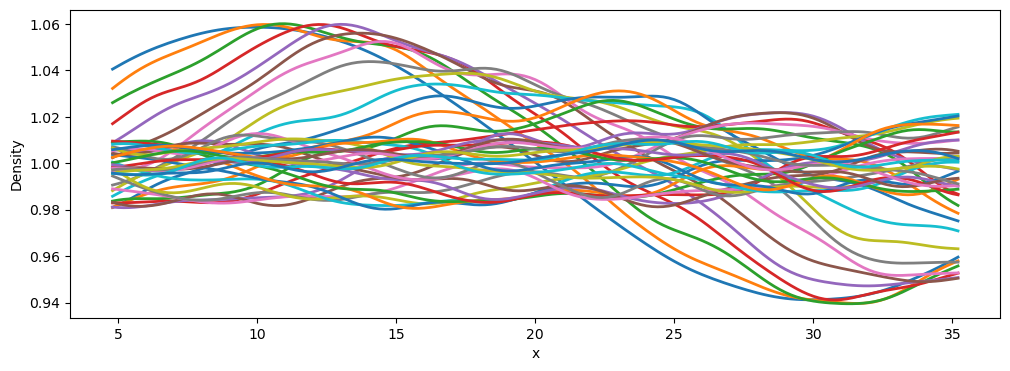

In [13]:
fig, ax = plt.subplots(figsize=(12,4))

for i, time in enumerate(times):
    N = run.GetNi(time)
    n = gF(N, sigma=6)

    n.plot(qty='value', ax=ax, ls='solid', lw=2.0, color=colors[i%10], ylabel='Density')

In [14]:
zob = run.GetE(0, merged=True)
zob = run.GetMassDensity(0, merged=True)
zob = run.GetNi(0, merged=True)
# zob = run.GetN(0, "protons", merged=True)
# zob = run.GetFlux(0, "protons", merged=True)
zob = run.GetVi(0, merged=True)

In [15]:
def sine_func(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

from scipy.optimize import curve_fit

n1_far = np.zeros(times.shape)
f1_far = np.zeros(times.shape)

for i, tim in enumerate(times):
    initial_guess = [0.1, 0.157, 0.0, 1.0]
    dn_func, x_fin = run.GetNi(tim, merged=True)['rho']
    x_ = x_fin[0]
    y_ = dn_func(x_)
    params, covariance = curve_fit(sine_func, x_, y_, p0=initial_guess)
    A_fit, B_fit, C_fit, D_fit = params
    n1_far[i] = np.fabs(A_fit)
    f1_far[i] = np.fabs(C_fit)

In [16]:
def lin_func(x, A, B):
    return A * x + B

pivot_f = 8

from scipy.optimize import curve_fit

initial_guess = [0.07, 0.0]
params, covariance = curve_fit(lin_func, times[:pivot_f], f1_far[:pivot_f], p0=initial_guess)
A_fit, B_fit = params

f1_fit = lin_func(times, A_fit, B_fit)

In [26]:
A_fit

np.float64(0.06321110751804049)

(0.0, 2.0)

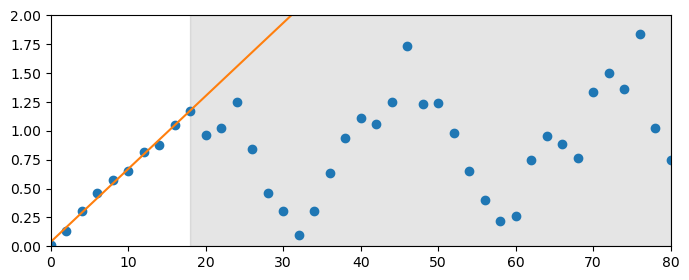

In [25]:
fig, ax = plt.subplots(figsize=(8,3))

ax.axvspan(times[pivot_f+1], times[-1], color='k', alpha=0.10)
ax.plot(times, f1_far, marker="o", color=colors[0], ls="None")
ax.plot(times, f1_fit, color=colors[1])
# 
# ax.text(60, 0.9*np.max(n1_fit), '$\\gamma_{{Landau}}$ : {:.4f}'.format(gamma_landau))
# ax.text(60, 0.8*np.max(n1_fit), '$\\gamma_{{PHARE}}$ : {:.4f}'.format(gamma_num))
# 
ax.set_xlim([0, 80])
ax.set_ylim([0.0, 2.0])
# ax.set_xlabel('Time')
# ax.set_ylabel('$N_1$ amplitude')

## Imaginary part of the angular frequency

But this ion acoustic mode is Landau damped, at a rate that we know. Its general form for a Maxwellian plasma is
$$
\gamma_L = \frac{- [\omega_r| \sqrt{\pi/8}}{(1+k^2 \lambda_{De}^2)^{3/2}} \left[ \left( \frac{T_e}{T_i} \right)^{3/2} \exp \left( - \frac{T_e/T_i}{2(1+k^2 \lambda_{De}^2)^{3/2}} + \sqrt{ \frac{m_e}{m_i} } \right) \right]
$$
This form is getting simpler in the hybrid case, that is $m_e/m_i \to 0$ and $\lambda_{De} \to 0$. Hence, this damping rate is simplifying as
$$
\gamma_L = - \sqrt{\frac{\pi}{8}} k c_s  \left( \frac{T_e}{T_i} \right)^{3/2} \exp \left[ - \frac{T_e}{2 T_i} \right]
$$

We know that we have to be in the case $T_e/T_i > 1$, but if this ratio is too large, the exponential term is driving the damping rate close to zero. We then decide to have $T_e = 0.2$ and $T_i = 0.1$.

Another precaution, is that to be as much as possible in the linear case, we take a density perturbation(sinusoidal) with an amplitude 0.06. The continuity equation in Fourier space gives
$$
-\imath \omega n_1 + \imath n_0 k V_1 = 0
$$
that is $V_1 = n_1 c_s$ for $n_0 = 1$. To be sure to pick up the right monochromatic ion acoustic mode, we then need to satisfy this polarisation in longitudinal velocity. While the mode is non-dispersive, this is important as the damping rate depends on the wave number $k$, so in a wave packet, each component would be damped at a different rate.

In [ ]:
Ti = 0.1
Te = 0.2
run_name = "ld_real"

In [ ]:
def exp_func(x, A, B, C):
    return A * np.exp(- B * x) + C

pivot = 8

from scipy.optimize import curve_fit

initial_guess = [0.04, 0.03, 0.0]
params, covariance = curve_fit(exp_func, times[pivot:], n1_far[pivot:], p0=initial_guess)
A_fit, B_fit, C_fit = params

n1_fit = exp_func(times, A_fit, B_fit, C_fit)

In [ ]:
gamma_num = B_fit
print("numerical fit  : {:.4f}".format(gamma_num))

L = 40
k = 2*np.pi/L
Gamma_e = 1
Gamma_i = 3
cs = np.sqrt(Gamma_e*Te+Gamma_i*Ti)
gamma_landau = np.sqrt(np.pi/8) * k * cs * np.power(Te/Ti, 1.5) * np.exp(- 0.5*Te/Ti)
print("analytical fit : {:.4f}".format(gamma_landau))

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))

ax.axvspan(times[0], times[pivot], color='k', alpha=0.10)
ax.plot([times[0], times[-1]], [0, 0], color='k', linestyle=':')
ax.plot(times, n1_far, marker="o", color=colors[0], ls="None")
ax.plot(times, n1_fit, color=colors[1])

ax.text(60, 0.9*np.max(n1_fit), '$\\gamma_{{Landau}}$ : {:.4f}'.format(gamma_landau))
ax.text(60, 0.8*np.max(n1_fit), '$\\gamma_{{PHARE}}$ : {:.4f}'.format(gamma_num))

ax.set_xlim([0, 80])
ax.set_ylim([-0.01, 0.11])
ax.set_xlabel('Time')
ax.set_ylabel('$N_1$ amplitude')